In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.ticker as mticker
import xarray as xr
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt, welch
from cartopy import crs,feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from pyproj import Geod

pd.options.display.max_rows = 4000

### Some functions 

#### Filtering functions

In [2]:
# more info https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass 
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(lowcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

def butter_lowpass_filter(data, lowcut, fs, order=3):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

#function for creating variance ellipses
#https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def eigsorted(cov):
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]   # The [::-1] slice reverses order sort order is largest to smallest
    return vals[order], vecs[:,order]

#### Functions for xarray

In [3]:
def tmean(x):
    return (x-x.mean())
def bandpassSD(x):
    return butter_bandpass_filter(x, lowcut_sd, highcut_sd, fs, order=3)
def bandpassDI(x):
    return butter_bandpass_filter(x, lowcut_di, highcut_di, fs, order=3)
def bandpassLP(x):
    return butter_lowpass_filter(x, lowcut_lp, fs, order=3)

### Read in dataset from HFRnet TDS OpenDAP into xarray

In [4]:
netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd')

#### clean up dataset

In [5]:
netcdf_data=netcdf_data.drop_vars(['dopx','dopy','time_bnds','depth_bnds','wgs84','processing_parameters','radial_metadata',
                       'depth','time_offset','hdop','number_of_sites','number_of_radials','time_run'])

### Set Time and Geographical limits

In [6]:
timeStart="2017-09-01T00:00:00"
timeStop="2017-12-01T00:00:00"
latStart=34.50
latStop=35.75
lonStart=-121.5
lonStop=-120.65

#### Calculate extent of geographical limits in KM

In [7]:
wgs84_geod = Geod(ellps='WGS84')
az12,az21,xdist = wgs84_geod.inv(lonStart,latStart,lonStop,latStart)
az12,az21,ydist = wgs84_geod.inv(lonStart,latStart,lonStart,latStop)
print("X extent: {:.1f} km \nY extent {:.1f} km".format(xdist/1000,ydist/1000))

X extent: 78.1 km 
Y extent 138.7 km


### Subset the data

#### Slice by time and lat/lon

In [8]:
data=netcdf_data.sel(time=slice(timeStart,timeStop),lat=slice(latStart,latStop),lon=slice(lonStart,lonStop))

#### linear interpolate in time

In [9]:
data['uint']=data['u'].interpolate_na(dim='time')
data['vint']=data['v'].interpolate_na(dim='time')

#### stack data over lat/lon

In [10]:
# associating data by lat/lon points for xarray operations
data_stacked=data.stack(geo=('lat','lon'))

#### de-mean data

In [11]:
# extract full timeseries and apply the xarray de-mean function (tmean) to each data point
data['udm']=data_stacked['uint'].groupby('geo').apply(tmean).unstack('geo')
data['vdm']=data_stacked['vint'].groupby('geo').apply(tmean).unstack('geo')

#### Create complex timeseries

In [12]:
# useful for rotary spectra and complex eofs
#interpolated dataset
data['uivint']=data['uint']+1j*data['vint']
#de-meaned dataset
data['uivdm']=data['udm']+1j*data['vdm']

#### Confirm there are no time gaps

In [13]:
# mean,max and min of diff should be the same if there are no gaps
timeDiff=np.diff(data.time)
timeMin=np.min(timeDiff)/np.timedelta64(1, 'm')
timeMax=np.max(timeDiff)/np.timedelta64(1, 'm')
timeMean=np.mean(timeDiff)/np.timedelta64(1, 'm')
print("Min: {:.0f} Max: {:.0f} Mean: {:.0f}".format(timeMin,timeMax,timeMean))

# this will plot the difference in timestep through timeseries in minutes
# should be a straight line
#plt.figure()
#plt.plot(timeDiff/np.timedelta64(1, 'm'))


Min: 60 Max: 60 Mean: 60


#### Calculate percentage coverage

In [14]:
# calculate the percent coverage of data at each cell
# assuming if there is data in u there is data in v
percCount=data['u'].count('time')/data['time'].size*100

# lat and lon for plotting
lon,lat=np.meshgrid(data['lon'].values,data['lat'].values)

#find the lat lon of grid points with data
#easiest way is to convert to dataframe, extract lat/lon indicies where there are data 
udf=percCount.to_dataframe()
udf.reset_index('lat',inplace=True)
udf.reset_index('lon',inplace=True)
glon=udf.lon[udf['u']>0].values
glat=udf.lat[udf['u']>0].values

### Plot some data

#### Percent coverage of the data

<IPython.core.display.Javascript object>


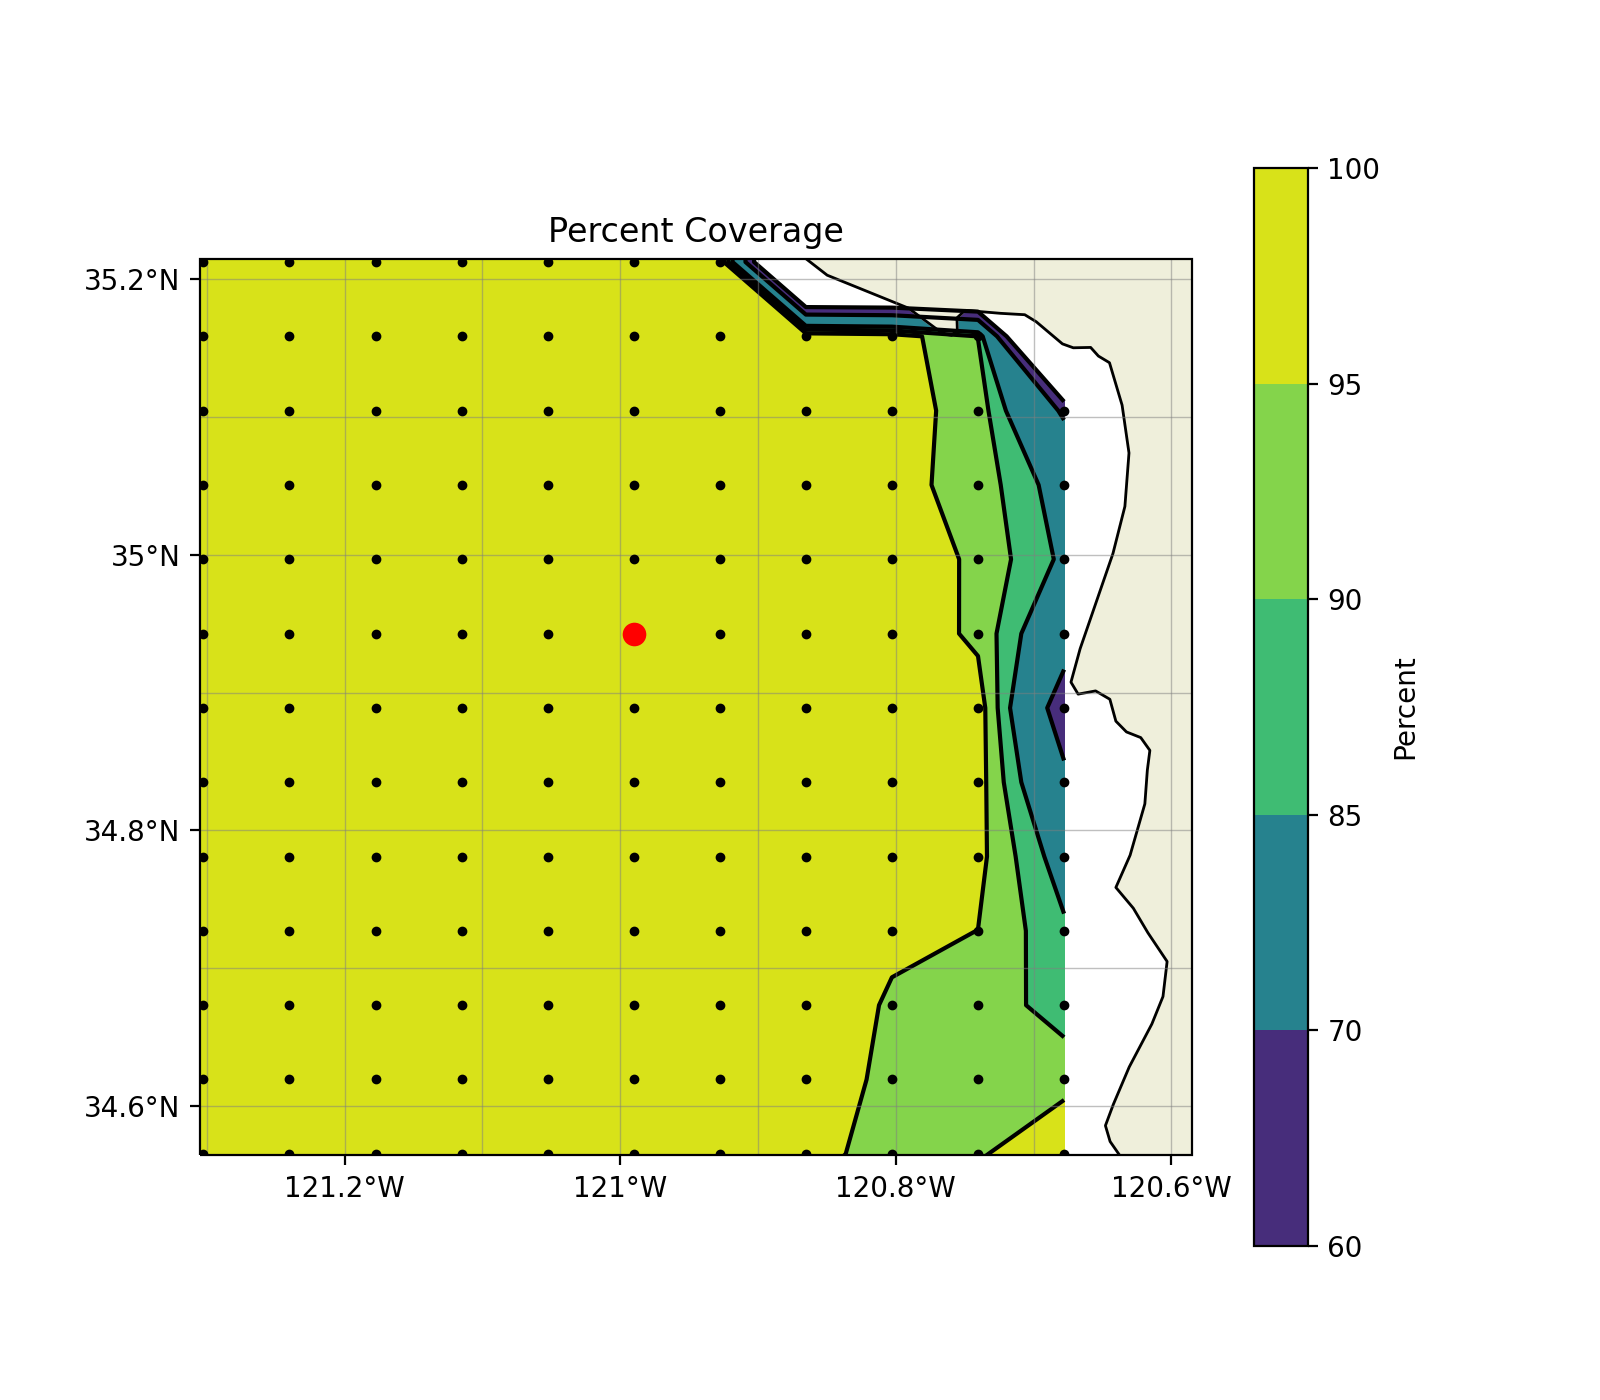

In [15]:
fig=plt.figure(figsize=(8,7))

# plot the basemap
ax = plt.axes(projection=crs.PlateCarree())
ax.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# plot color filled contours and contour lines
cn=ax.contourf(lon,lat,percCount,cmap='viridis',levels=[60,70,85,90,95,100])
ax.contour(lon,lat,percCount,levels=[60,70,85,90,95,100],colors='k')

# plot grid points where data exists
ax.plot(glon,glat,'k.',ms=5)
ax.plot(data.lon[8],data.lat[8],'r.',ms=15)


# finish up plot
ax.set_title('Percent Coverage')
ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax.set_extent([-121.305,-120.585,34.564,35.215])
ax.coastlines(resolution='10m',color='k')
plt.colorbar(cn,label='Percent')

#### Plot a single time observation of the currents

<IPython.core.display.Javascript object>


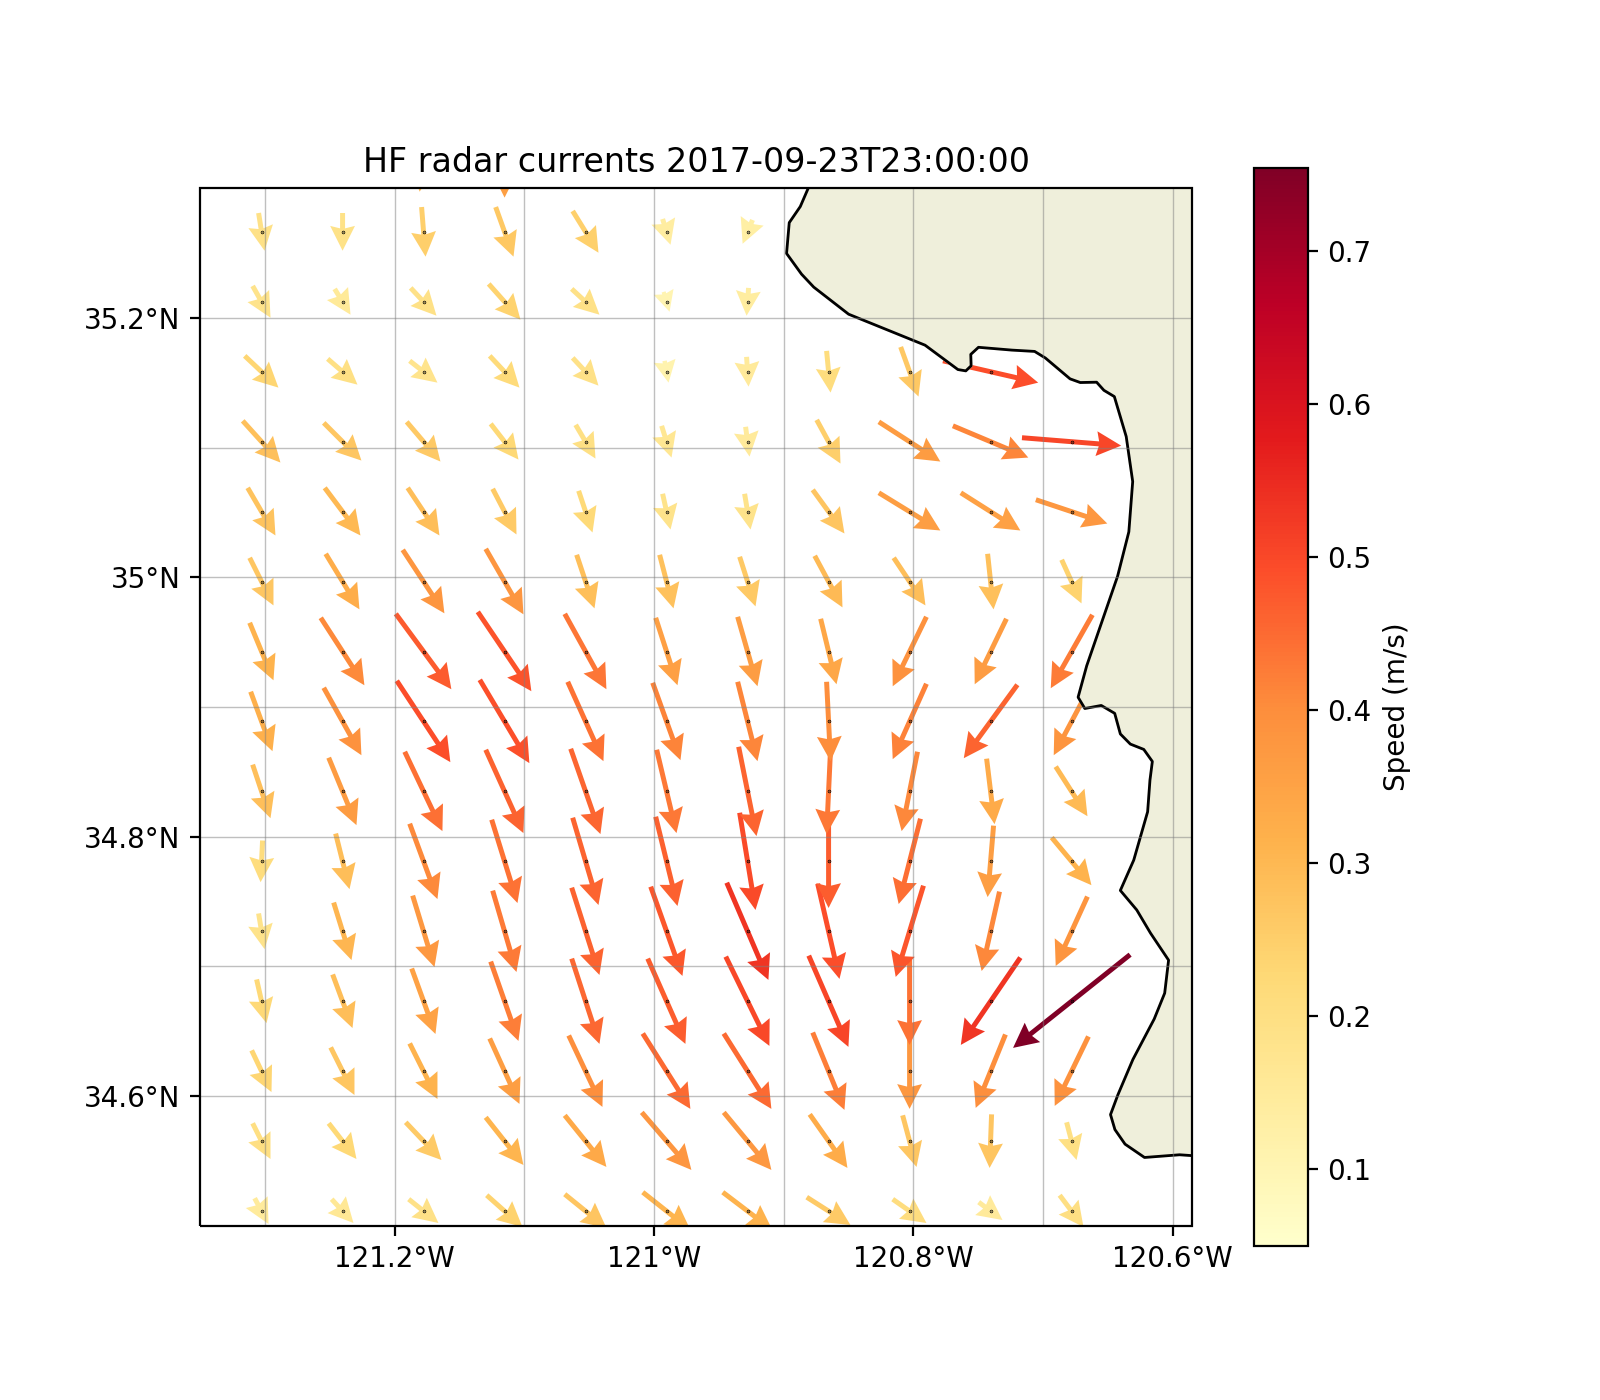

In [16]:
obTime="2017-09-23T23:00:00"

# extract data at specified time
u=data['uint'].sel(time=obTime)
v=data['vint'].sel(time=obTime)
currMag=np.sqrt(u**2+v**2)

fig=plt.figure(figsize=(8,7))

# plot the basemap and grid points
ax = plt.axes(projection=crs.PlateCarree())
ax.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.plot(glon,glat,'k.',ms=.5)

# use quiver to plot current vectors with colormap of current magnitude
currents=ax.quiver(lon,lat,u,v,currMag,cmap='YlOrRd',scale=5,width=.005,headwidth=5,pivot='mid')
plt.colorbar(currents,label='Speed (m/s)')

# finish up plot
ax.set_title('HF radar currents '+obTime)
ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax.set_extent([-121.35,-120.585,34.5,35.3])
ax.coastlines(resolution='10m',color='k')


### Basic statistics

#### Current mean - vector plot

<IPython.core.display.Javascript object>


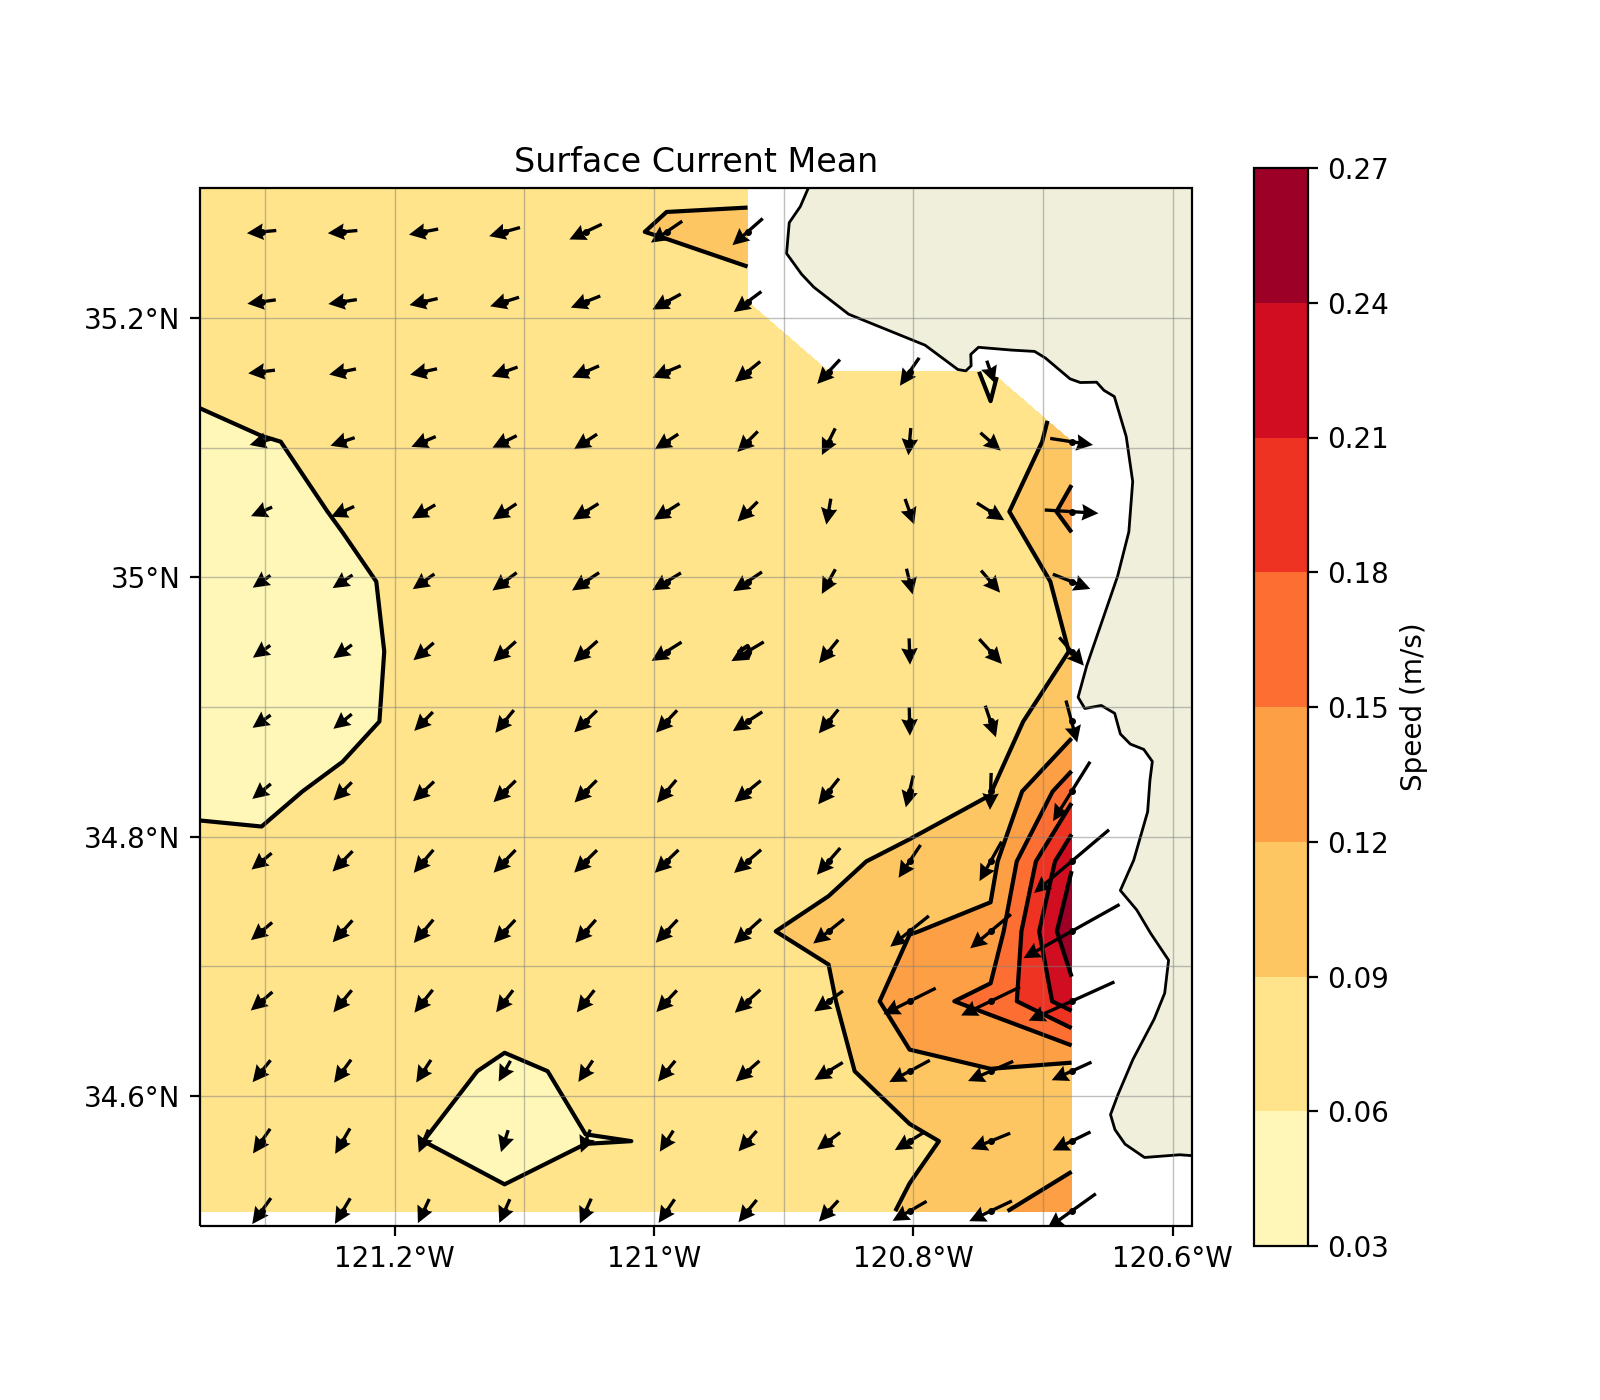

In [17]:
# calculate mean magnitude and direction of current field
meanMag=np.sqrt(data['uint'].mean('time')**2+data['vint'].mean('time')**2)
meanDir=np.rad2deg(np.arctan2(data['vint'].mean('time'),data['uint'].mean('time')))

# set up map
fig=plt.figure(figsize=(8,7))
ax8 = plt.axes(projection=crs.PlateCarree())
ax8.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax8.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax8.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax8.xaxis.set_major_formatter(LongitudeFormatter())
ax8.yaxis.set_major_formatter(LatitudeFormatter())

# plot colored contours and contour line
CF=ax8.contourf(lon,lat,meanMag,cmap='YlOrRd')
ax8.contour(lon,lat,meanMag,colors='k',linestyles='solid')

# plot grid points
ax8.plot(glon,glat,'k.',ms=3)

# plot current vectors
ax8.quiver(lon,lat,data['uint'].mean('time'),data['vint'].mean('time'),headwidth=5,pivot='mid')
plt.colorbar(CF,label="Speed (m/s)")

# finish up plot
ax8.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax8.set_title('Surface Current Mean')
ax8.set_extent([-121.35,-120.585,34.5,35.3])
ax8.coastlines(resolution='10m',color='k')

#### Current mean - component plots

<IPython.core.display.Javascript object>


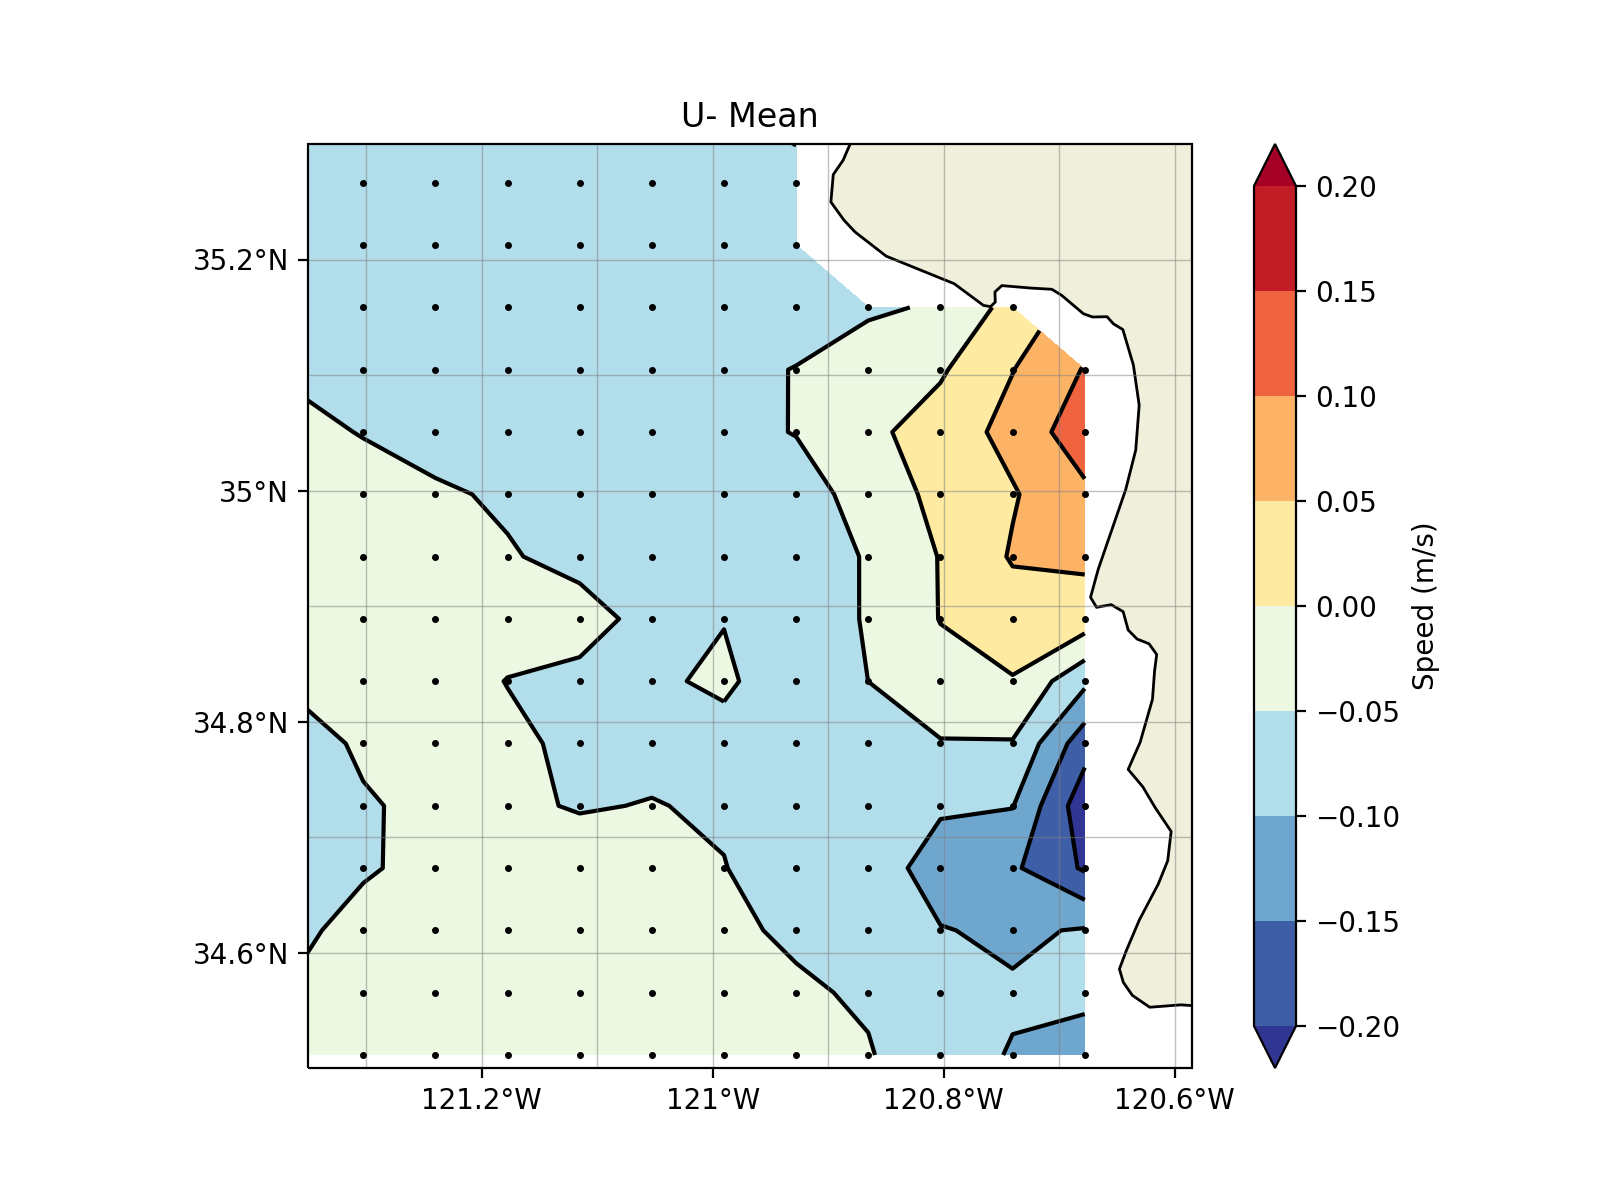

<IPython.core.display.Javascript object>


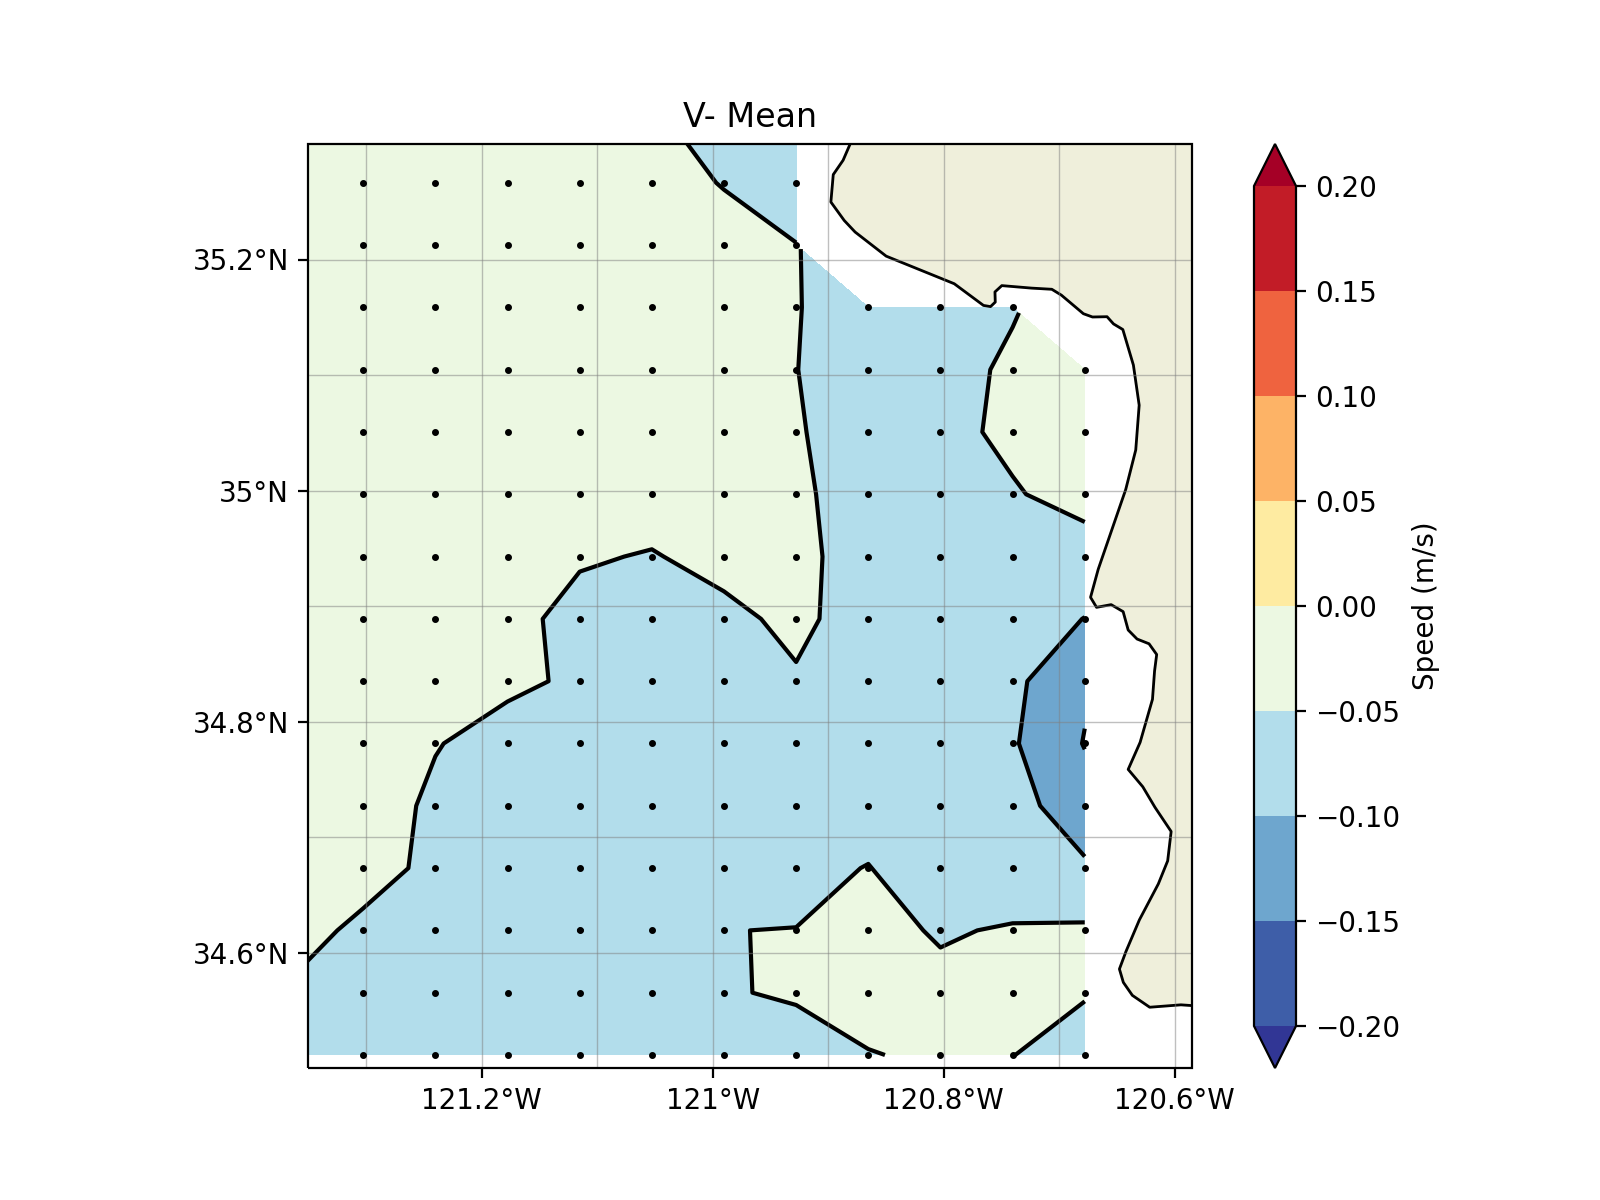

In [18]:
u_mean=data['uint'].mean('time')
v_mean=data['vint'].mean('time')

# set up map
fig=plt.figure(figsize=(8,6))
ax9 = plt.axes(projection=crs.PlateCarree())
ax9.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax9.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax9.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax9.xaxis.set_major_formatter(LongitudeFormatter())
ax9.yaxis.set_major_formatter(LatitudeFormatter())

# plot U component mean color contour and contour lines
contour_levels=[-.2,-.15,-.1,-.05,0,.05,.1,.15,.2]
CF=ax9.contourf(lon,lat,u_mean,cmap='RdYlBu_r',vmin=-0.2,vmax=0.2,levels=contour_levels,extend='both')
ax9.contour(lon,lat,u_mean,levels=contour_levels,colors='k',linestyles='solid')
plt.colorbar(CF,label="Speed (m/s)")

# plot grid points
ax9.plot(glon,glat,'k.',ms=3)

# finish up plot
ax9.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax9.coastlines(resolution='10m',color='k')
ax9.set_title('U- Mean')
ax9.set_extent([-121.35,-120.585,34.5,35.3])

# set up map
fig=plt.figure(figsize=(8,6))
ax9 = plt.axes(projection=crs.PlateCarree())
ax9.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax9.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax9.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax9.xaxis.set_major_formatter(LongitudeFormatter())
ax9.yaxis.set_major_formatter(LatitudeFormatter())

# plot U component mean color contour and contour lines
contour_levels=[-.2,-.15,-.1,-.05,0,.05,.1,.15,.2]
CF=ax9.contourf(lon,lat,v_mean,cmap='RdYlBu_r',vmin=-0.2,vmax=0.2,levels=contour_levels,extend='both')
ax9.contour(lon,lat,v_mean,levels=contour_levels,colors='k',linestyles='solid')
plt.colorbar(CF,label="Speed (m/s)")

# plot grid points
ax9.plot(glon,glat,'k.',ms=3)

# finish up plot
ax9.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax9.coastlines(resolution='10m',color='k')
ax9.set_title('V- Mean')
ax9.set_extent([-121.35,-120.585,34.5,35.3])

### Rotary power spectra

<IPython.core.display.Javascript object>


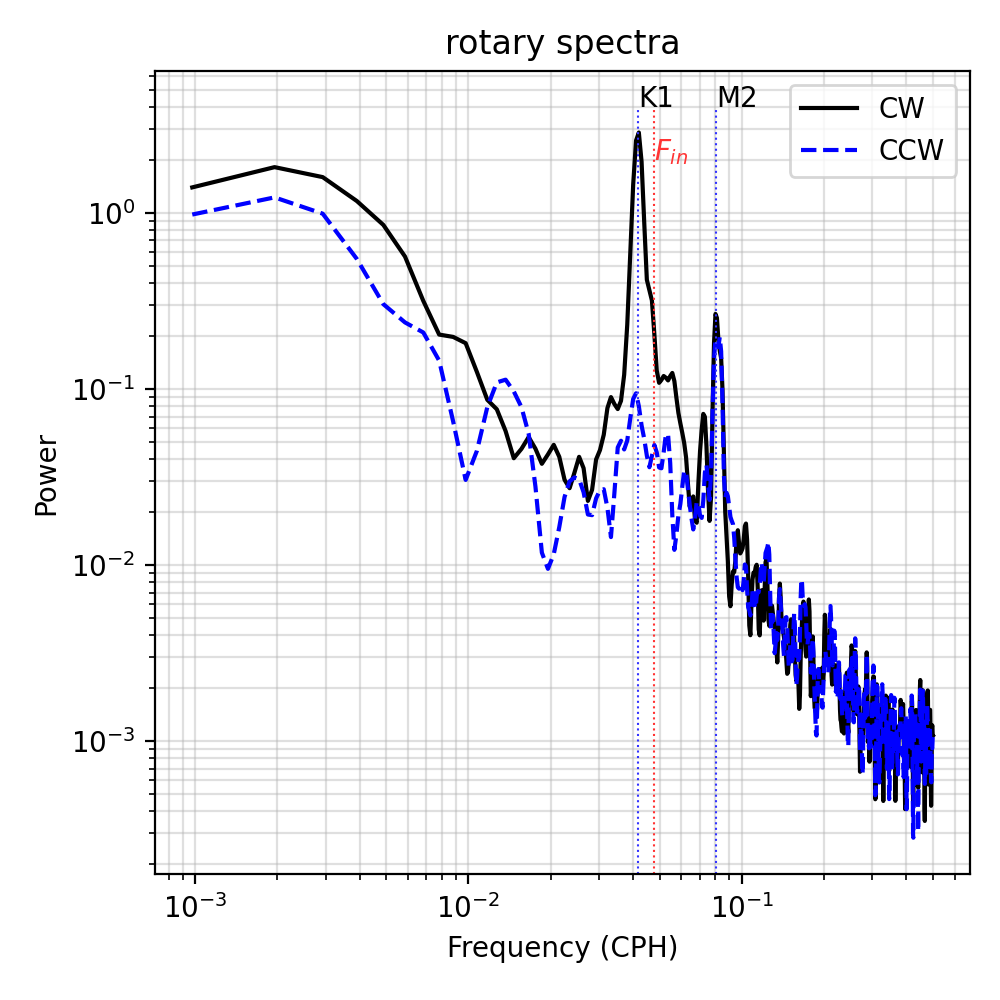

In [19]:
# Rotary spectra finds spectral components represented in clockwise and counter-clockwise rotating vectors
# ie inertial currents rotate CW in northern hemisphere

# Extract data from a single lat/lon point
# use .sel if you want to designate point using actual lat and lon values
ilat=8
ilon=8
pdata=data.isel(lat=ilat,lon=ilon)

# use welch's method to estimate power spectral density. two sided 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
freqs, psd = welch(pdata['uivdm'],return_onesided=False,nperseg=512,nfft=1024,noverlap=256,window="hann")

# seperate CW (-) and CCW (+)
freqCCW = freqs[np.where(freqs>0)]
psdCCW = psd[np.where(freqs>0)]
freqCW = freqs[np.where(freqs<0)]
psdCW = psd[np.where(freqs<0)]

# calculate coriolis frequency and inertial period
coriolisFreq=2*.727221e-4*np.sin(np.deg2rad(data.lat.isel(lat=ilat).values))
periodIn = ((2*np.pi)/coriolisFreq)/60/60
#print(periodIn)

# set up plot
fig4=plt.figure(figsize=(5,5))
ax4=plt.subplot()

# plot spectra
ax4.loglog(-freqCW, psdCW,'k-',label="CW")
ax4.loglog(freqCCW, psdCCW,'b--',label="CCW")

# plot lines for M2 (12.42hr), K1 (23.93) and Inertial Period
ax4.loglog([1/12.42,1/12.42],[0,4],':',color='#3333ff',linewidth=.75)
ax4.loglog([1/23.93,1/23.93],[0,4],':',color='#3333ff',linewidth=.75)
ax4.loglog([1/periodIn,1/periodIn],[0,4],':',color='#ff3333',linewidth=.75)
ax4.text(1/20.921,2,'$F_{in}$',color='#ff3333')
ax4.text(1/23.93,4,'K1')
ax4.text(1/12.42,4,'M2')

# finish up plot
ax4.legend()
ax4.grid(which='both',alpha=.4)
plt.title('rotary spectra')
plt.xlabel('Frequency (CPH)')
plt.ylabel('Power')
plt.tight_layout()

### Filter currents

#### Design Filters

<IPython.core.display.Javascript object>


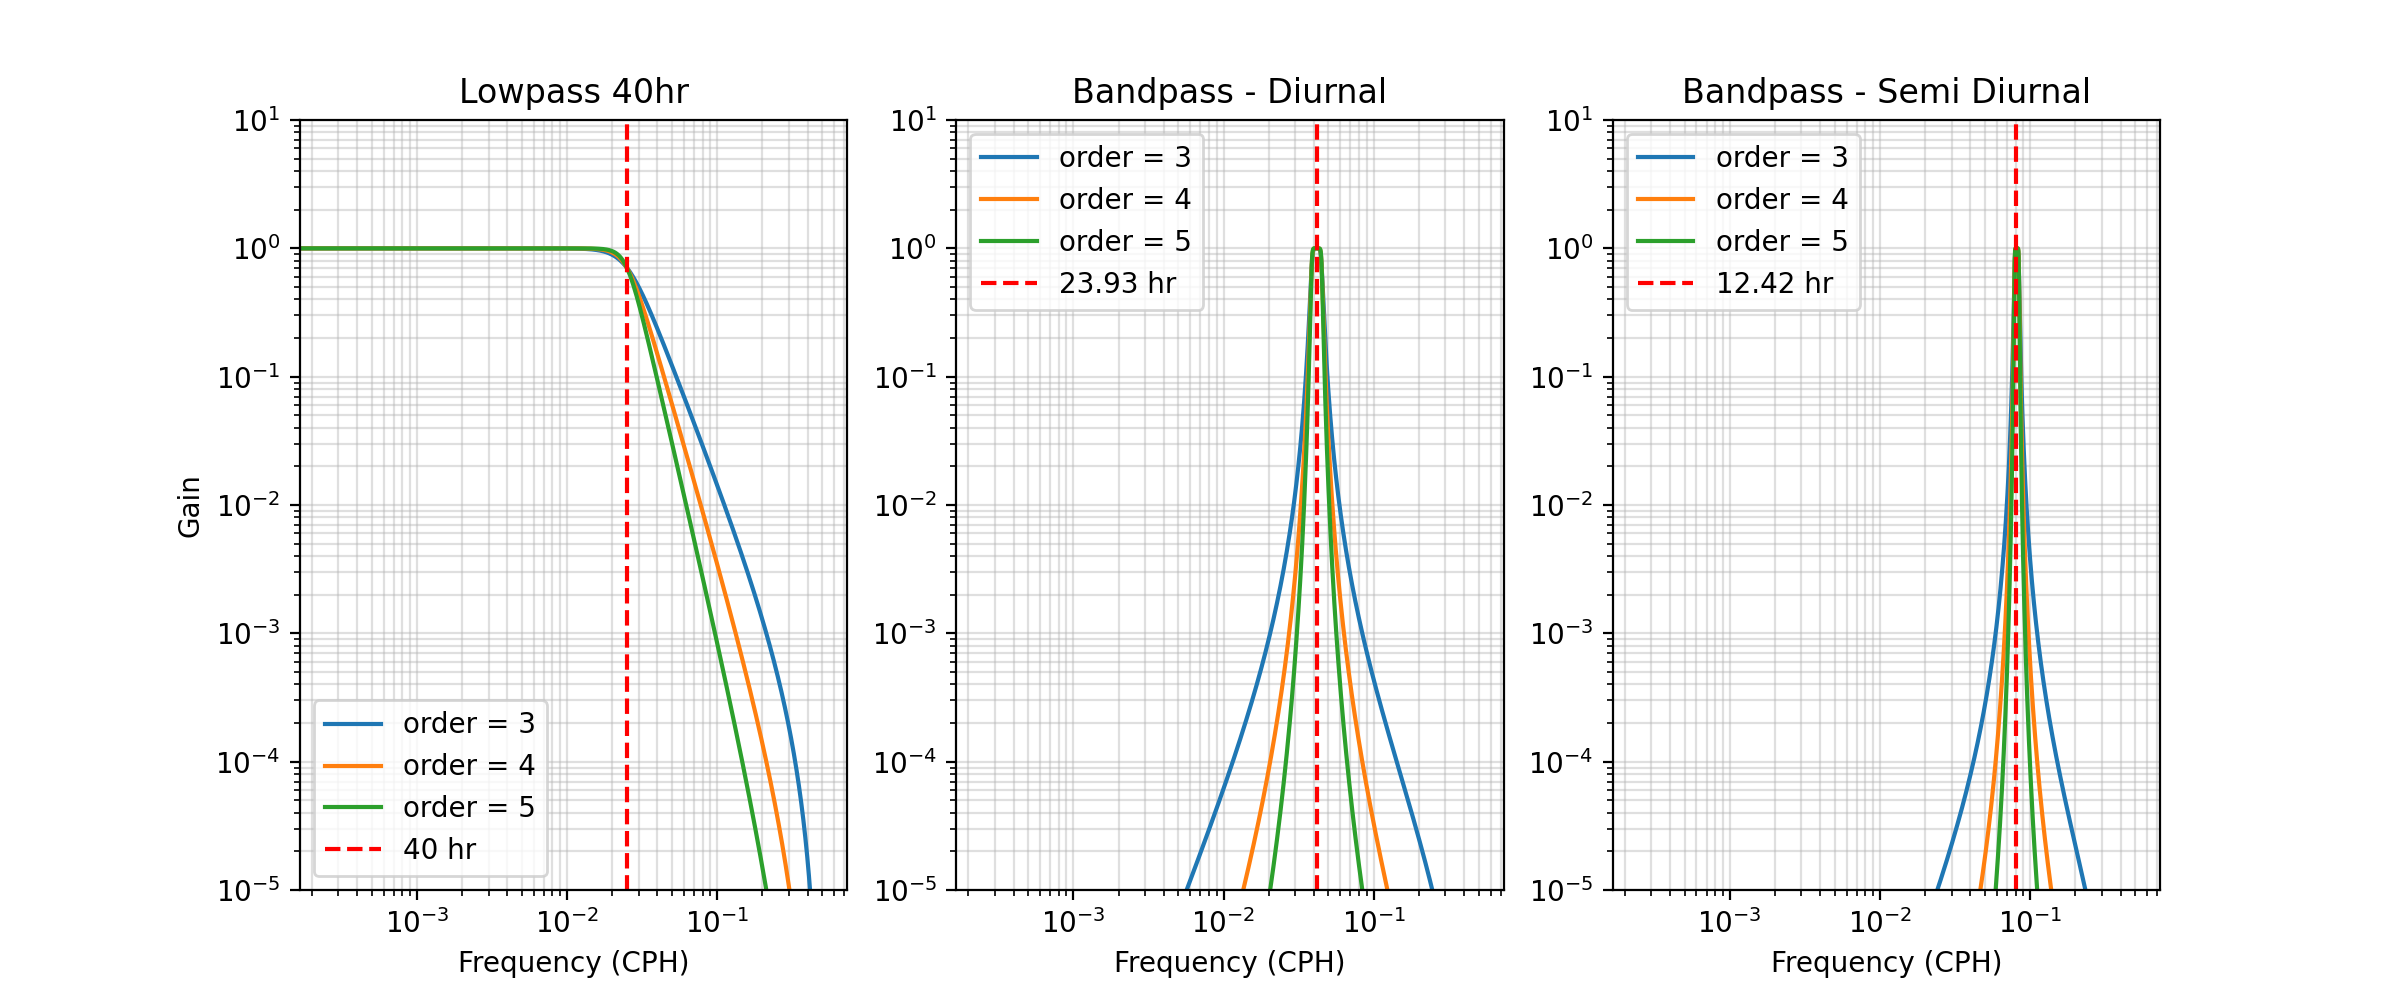

In [20]:
#### sampling frequency
fs = 1/3600 # 1 sample per hour

# Filter cutoffs in Hz - will later multiply by fs to plot in cycle per hour
# Sample rate and desired cutoff frequencies (in Hz).

#Semi-diurnal filter 
#M2=12.42, S2=12, N2=12.658
sd_high=11.9
sd_low=12.7
lowcut_sd=fs*1/sd_low
highcut_sd=fs*1/sd_high

# Diurnal filter
#K1=23.934,O1=25.819,OO1=22.306
di_high=22.2
di_low=25.9
lowcut_di=fs*1/di_low
highcut_di=fs*1/di_high

# Low Pass
# 40 hour low pass
lowcut_lp = fs*1/40     

# Plot the frequency response for a few different orders.
# divide by fs to get CPH
fig1=plt.figure(figsize=(12,5))
ax1_1=plt.subplot(131)
for order in [3, 4, 5]:
    b, a = butter_lowpass(lowcut_lp, fs, order=order)
    w, h = freqz(b, a, worN=2048) # worN is number of frequencies computed 
    ax1_1.loglog((fs * 0.5 / np.pi) / fs * w, abs(h), label="order = %d" % order)

ax1_1.loglog([1/40,1/40],[0,10],'r--',label='40 hr')

ax1_1.set_ylim((10e-06,10))
ax1_1.set_xlabel('Frequency (CPH)')
ax1_1.set_ylabel('Gain')
ax1_1.set_title('Lowpass 40hr')
ax1_1.grid(which='both',alpha=.4)
ax1_1.legend(loc='best')

ax1_2=plt.subplot(132)
for order in [3, 4, 5]:
    b, a = butter_bandpass(lowcut_di, highcut_di, fs, order=order)
    w, h = freqz(b, a, worN=2048)
    ax1_2.loglog((fs * 0.5 / np.pi) / fs * w, abs(h), label="order = %d" % order)

ax1_2.loglog([1/23.93,1/23.93],[0,10],'r--',label='23.93 hr')
ax1_2.set_ylim((10e-06,10))
ax1_2.set_xlabel('Frequency (CPH)')
ax1_2.set_title('Bandpass - Diurnal')
ax1_2.grid(which='both',alpha=.4)
ax1_2.legend(loc='best')

ax1_3=plt.subplot(133)
for order in [3, 4, 5]:
    b, a = butter_bandpass(lowcut_sd, highcut_sd, fs, order=order)
    w, h = freqz(b, a, worN=2048)
    ax1_3.loglog((fs * 0.5 / np.pi)/fs * w, abs(h), label="order = %d" % order)

ax1_3.loglog([1/12.42,1/12.42],[0,10],'r--',label='12.42 hr')
ax1_3.set_ylim((10e-06,10))
ax1_3.set_xlabel('Frequency (CPH)')
ax1_3.set_title('Bandpass - Semi Diurnal')
ax1_3.grid(which='both',alpha=.4)
ax1_3.legend(loc='best')


#### Apply the filters

In [21]:
# this needs to happen to clean up data for filtering
data_stacked=data_stacked.fillna(0)

In [22]:
# Low pass filter 
data['ulp']=data_stacked['uint'].groupby('geo').apply(bandpassLP).unstack('geo')
data['vlp']=data_stacked['vint'].groupby('geo').apply(bandpassLP).unstack('geo')

# Semi-diurnal filter
data['usd']=data_stacked['uint'].groupby('geo').apply(bandpassSD).unstack('geo')
data['vsd']=data_stacked['vint'].groupby('geo').apply(bandpassSD).unstack('geo')

# Diurnal filter
data['udi']=data_stacked['uint'].groupby('geo').apply(bandpassDI).unstack('geo')
data['vdi']=data_stacked['vint'].groupby('geo').apply(bandpassDI).unstack('geo')

# contructed currents low pass + diurnal + semi diurnal
data['filtu']=data['ulp']+data['usd']+data['udi']
data['filtv']=data['vlp']+data['vsd']+data['vdi']

# residual current
data['resu']=data['uint']-data['filtu']
data['resv']=data['vint']-data['filtv']


#### Plot filtered currents

In [23]:
# create time variable for plotting purposes
dates=data.time.to_pandas()

# lat and lon indices
# use .sel if you want to show actual lat and lon values
ilat=8
ilon=8

# extract data from lat/lon grid point
pdata=data.isel(lat=ilat,lon=ilon)

# create a Low Pass + Diurnal + Semi-diurnal field
filtu=pdata['filtu'].values
filtv=pdata['filtv'].values

# create a residual field
resu=pdata['resu'].values
resv=pdata['resv'].values

# calculate sum of squares
# residual sum of squares
ssum_resu=np.sum(resu**2)
ssum_resv=np.sum(resv**2)

# filtered sum of squares
ssum_filtu=np.sum(filtu**2)
ssum_filtv=np.sum(filtv**2)

# interpolated sum of squares
ssum_u=np.sum(pdata['uint'].values**2)
ssum_v=np.sum(pdata['vint'].values**2)

# find variance explained of filtered field
filtu_varexp=ssum_filtu/ssum_u*100
filtv_varexp=ssum_filtv/ssum_v*100
print("Variance explained by filtered fields\nU: {:.1f}%\nV: {:.1f}%".format(filtu_varexp,filtv_varexp))

Variance explained by filtered fields
U: 79.3%
V: 87.4%


<IPython.core.display.Javascript object>


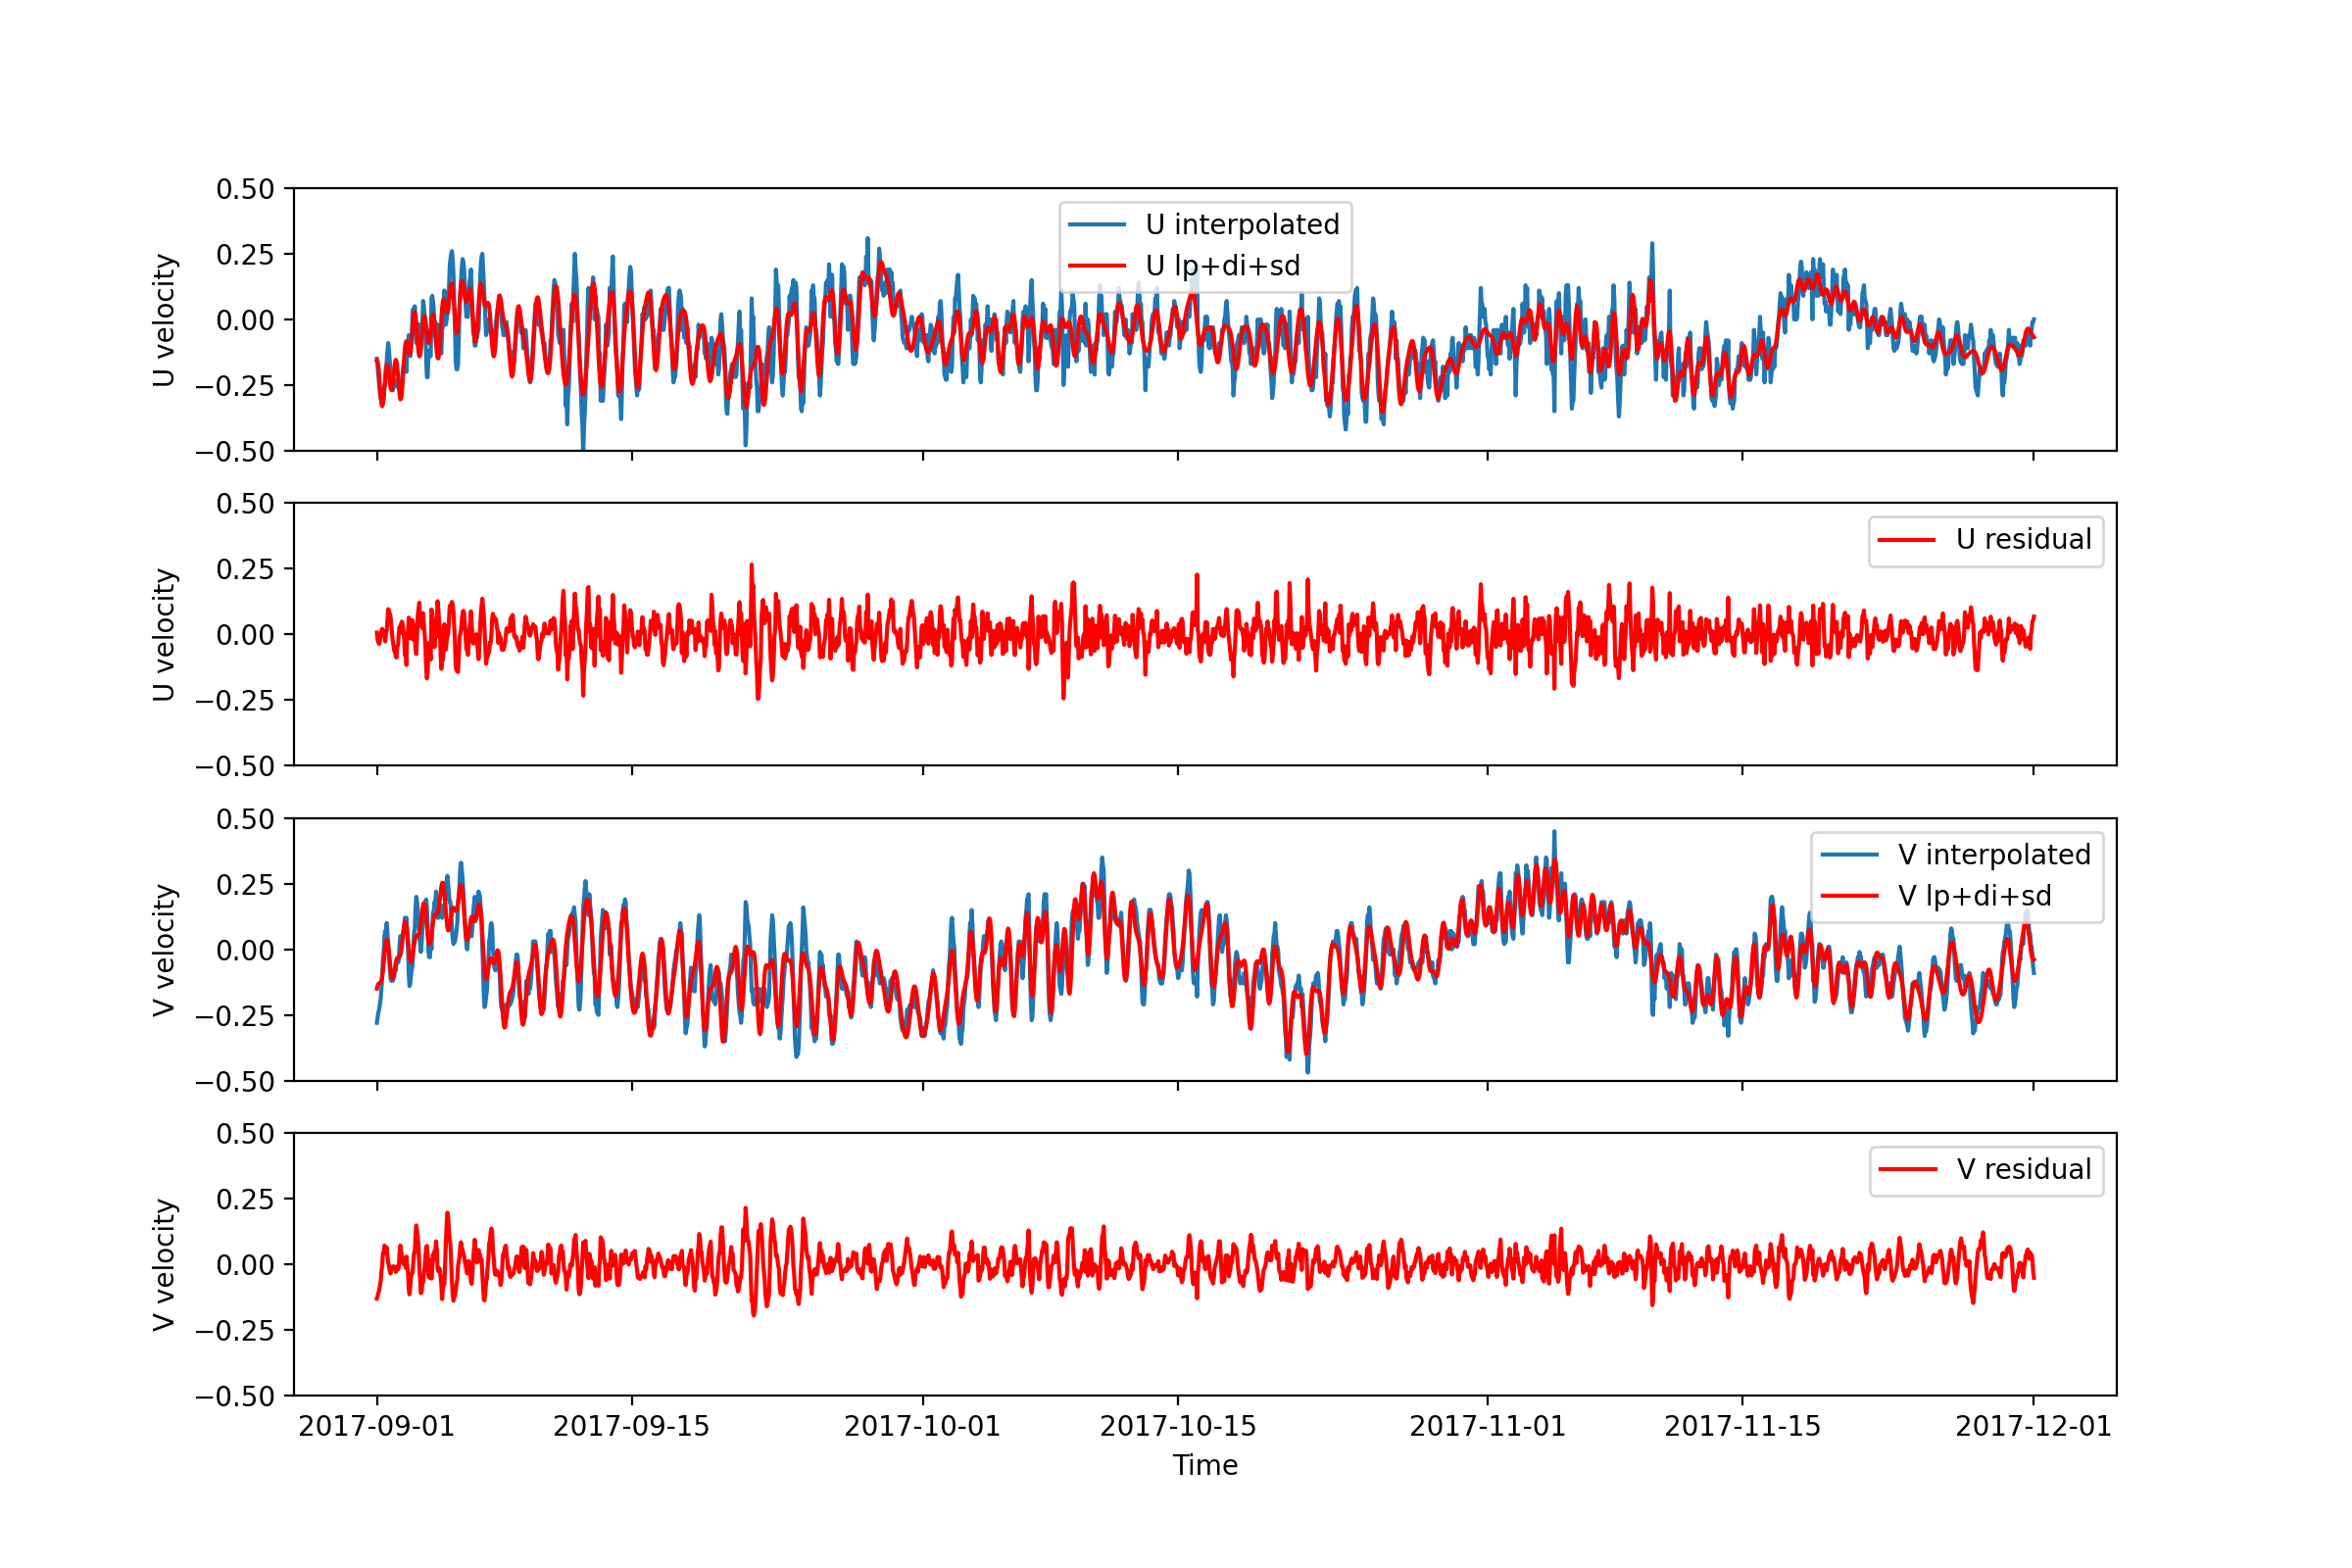

In [24]:
fig3=plt.figure(figsize=(12,8))

# Plot interpolated U currents superimposed with reconstructed 
ax3_1=plt.subplot(411)
ax3_1.plot(dates,pdata['uint'],label='U interpolated')
ax3_1.plot(dates,filtu,'r',label='U lp+di+sd')
ax3_1.set_ylabel('U velocity')
ax3_1.set_ylim([-.5,.5])
ax3_1.xaxis.set_ticklabels([])
ax3_1.legend()

# plot U residuals
ax3_2=plt.subplot(412)
ax3_2.plot(dates,resu,'r',label='U residual')
ax3_2.set_ylabel('U velocity')
ax3_2.set_ylim([-.5,.5])
ax3_2.xaxis.set_ticklabels([])
ax3_2.legend()

# Plot interpolated V currents superimposed with reconstructed 
ax3_3=plt.subplot(413)
ax3_3.plot(dates,pdata['vint'],label='V interpolated')
ax3_3.plot(dates,filtv,'r',label='V lp+di+sd')
ax3_3.legend()
ax3_3.set_ylim([-.5,.5])
ax3_3.xaxis.set_ticklabels([])
ax3_3.set_ylabel('V velocity')

# plot V residuals
ax3_4=plt.subplot(414)
ax3_4.plot(dates,resv,'r',label='V residual')
ax3_4.set_ylabel('V velocity')
ax3_4.set_ylim([-.5,.5])
ax3_4.legend()
ax3_4.set_xlabel('Time');




### Find covariance error ellipses of constructed and residual currents

#### Example covariance error ellipse 

<IPython.core.display.Javascript object>


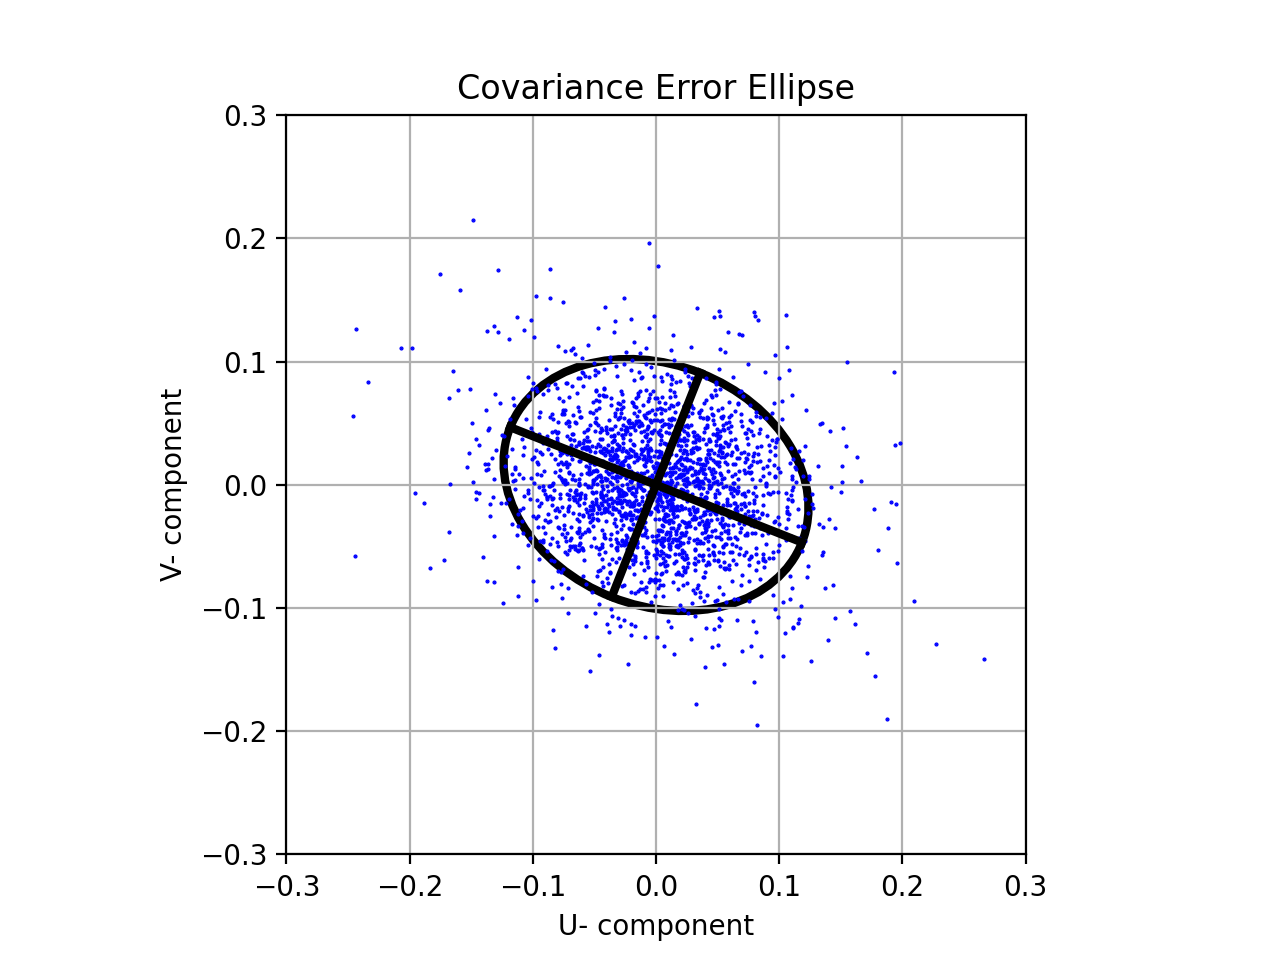

In [25]:
u=resu
v=resv

# number of std dev to draw ellipse around data
nstd = 2  

# calculate covariance of current field
cov = np.cov(u,v)

# get sorted eigenvalues and vectors of the covariance matrix
vals, vecs = eigsorted(cov)

# calculate ellipse parameters for plotting
# theta is angle of ellipse
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

# find width and height of ellipse
# typically major axis = 1st EV, minor axis = 2nd EV
w, h = 2 * nstd * np.sqrt(vals) 

#end points of major and minor axis lines
endy=w/2*np.sin(np.deg2rad(theta))
endx=w/2*np.cos(np.deg2rad(theta))
endyy=h/2*np.sin(np.deg2rad(theta+90))
endxx=h/2*np.cos(np.deg2rad(theta+90))

# create plot
fig7=plt.figure()
ax7 = plt.subplot(111,aspect='equal')

# plot covariance ellipse
ell = Ellipse(xy=(np.mean(u), np.mean(v)),
              width=w, height=h,
              angle=theta, color='black',linewidth=3)
ell.set_facecolor('none')
ax7.add_patch(ell)

# plot scatter of u,v values
ax7.plot(u, v,'b.',ms=1)

# plot major and minor axis lines
ax7.plot([0,endx],[0,endy],'k',linewidth=3)
ax7.plot([0,endxx],[0,endyy],'k',linewidth=3)
ax7.plot([0,-endx],[0,-endy],'k',linewidth=3)
ax7.plot([0,-endxx],[0,-endyy],'k',linewidth=3)

ax7.set_xlim([-.3,.3])
ax7.set_ylim([-.3,.3])
ax7.set_xlabel('U- component')
ax7.set_ylabel('V- component')
ax7.set_title('Covariance Error Ellipse')
ax7.grid()

#### Calculate the error ellipses for filtered and residual signals

In [26]:
# declare empty arrays for xarray dataset
data['varw_filt']=xr.DataArray(None,dims=('lat','lon'),coords={'lat':data.lat,'lon':data.lon})
data['varh_filt']=xr.DataArray(None,dims=('lat','lon'),coords={'lat':data.lat,'lon':data.lon})
data['vart_filt']=xr.DataArray(None,dims=('lat','lon'),coords={'lat':data.lat,'lon':data.lon})
data['varw_res']=xr.DataArray(None,dims=('lat','lon'),coords={'lat':data.lat,'lon':data.lon})
data['varh_res']=xr.DataArray(None,dims=('lat','lon'),coords={'lat':data.lat,'lon':data.lon})
data['vart_res']=xr.DataArray(None,dims=('lat','lon'),coords={'lat':data.lat,'lon':data.lon})

# loop through each lat and lon and calculate covariance ellipse
for i in np.arange(0,data.lat.size):
    for j in np.arange(0,data.lon.size):
        try:
            # First find ellipses for filtered dataset
            cu=np.nan_to_num(data['filtu'][:,i,j])
            cv=np.nan_to_num(data['filtv'][:,i,j])
            cov = np.cov(cu,cv)
            vals, vecs = eigsorted(cov)
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            w, h = 2 * nstd * np.sqrt(vals) # typically major axis = 1st EV, minor axis = 2nd EV
            data['varh_filt'][i,j]=h
            data['varw_filt'][i,j]=w
            data['vart_filt'][i,j]=theta
            
            #now find ellipses for residual dataset
            cu=np.nan_to_num(data['resu'][:,i,j])
            cv=np.nan_to_num(data['resv'][:,i,j])
            cov = np.cov(cu,cv)
            vals, vecs = eigsorted(cov)
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            w, h = 2 * nstd * np.sqrt(vals) # typically major axis = 1st EV, minor axis = 2nd EV
            data['varh_res'][i,j]=h
            data['varw_res'][i,j]=w
            data['vart_res'][i,j]=theta
        except:
            print('missed,',np.nan_to_num(data['uint'][:,i,j]))
            print(cov)

#data.lat.loc

#### plot current ellipse for filtered data

<IPython.core.display.Javascript object>


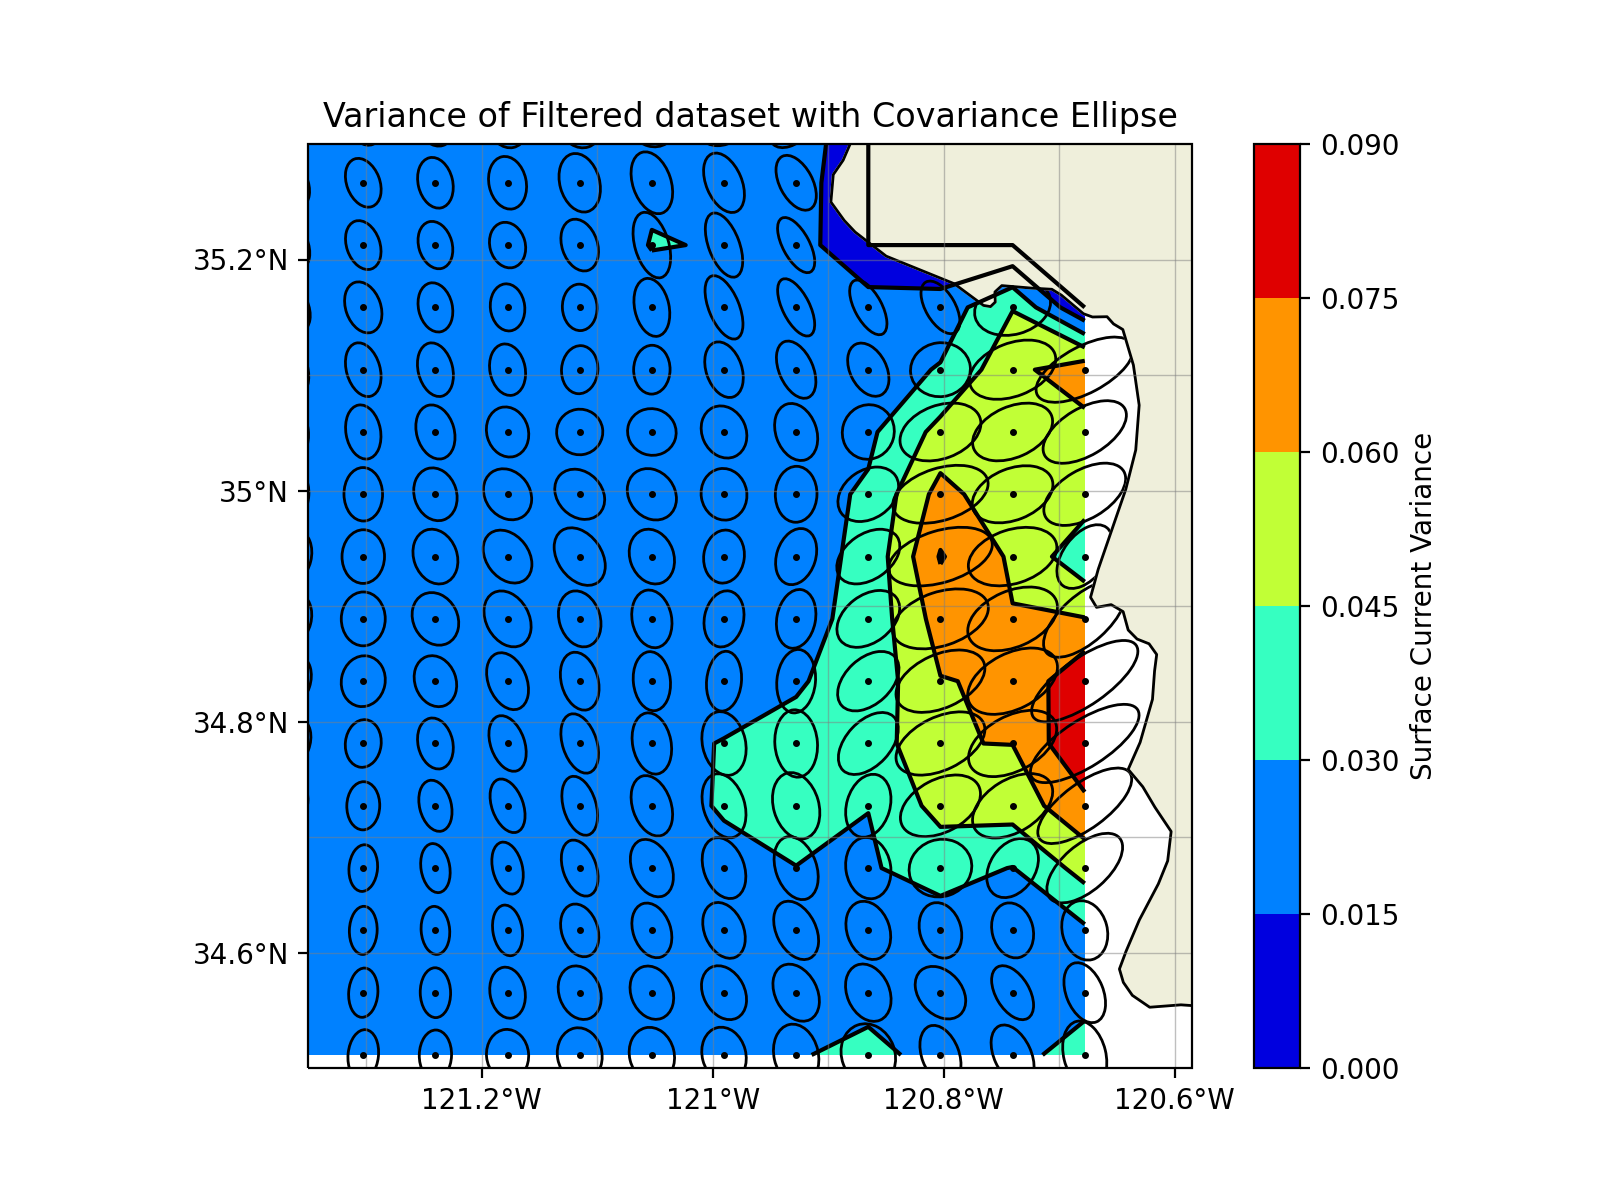

In [27]:
variance=np.sqrt(data['filtu'].var('time')**2+data['filtv'].var('time')**2)
pscale=12

fig=plt.figure(figsize=(8,6))
ax8 = plt.axes(projection=crs.PlateCarree())
ax8.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax8.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax8.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax8.xaxis.set_major_formatter(LongitudeFormatter())
ax8.yaxis.set_major_formatter(LatitudeFormatter())
for i in np.arange(0,data.lat.size):
    for j in np.arange(0,data.lon.size):
        w=data['varw_filt'].isel(lat=i,lon=j)
        h=data['varh_filt'].isel(lat=i,lon=j)
        theta=data['vart_filt'].isel(lat=i,lon=j)
        
        ell = Ellipse(xy=(data.lon.isel(lon=j),data.lat.isel(lat=i)),
              width=w/pscale, height=h/pscale,
              angle=theta, color='black',linewidth=1)
        ell.set_facecolor('none')
        ax8.add_patch(ell)
        
ax8.set_extent([-121.35,-120.585,34.5,35.3])

CF=ax8.contourf(lon,lat,variance,cmap='jet')
ax8.contour(lon,lat,variance,colors='k')
ax8.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax8.plot(glon,glat,'k.',ms=3)
ax8.set_title('Variance of Filtered dataset with Covariance Ellipse')
plt.colorbar(CF,label="Surface Current Variance")
ax8.coastlines(resolution='10m',color='k')




/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


<IPython.core.display.Javascript object>


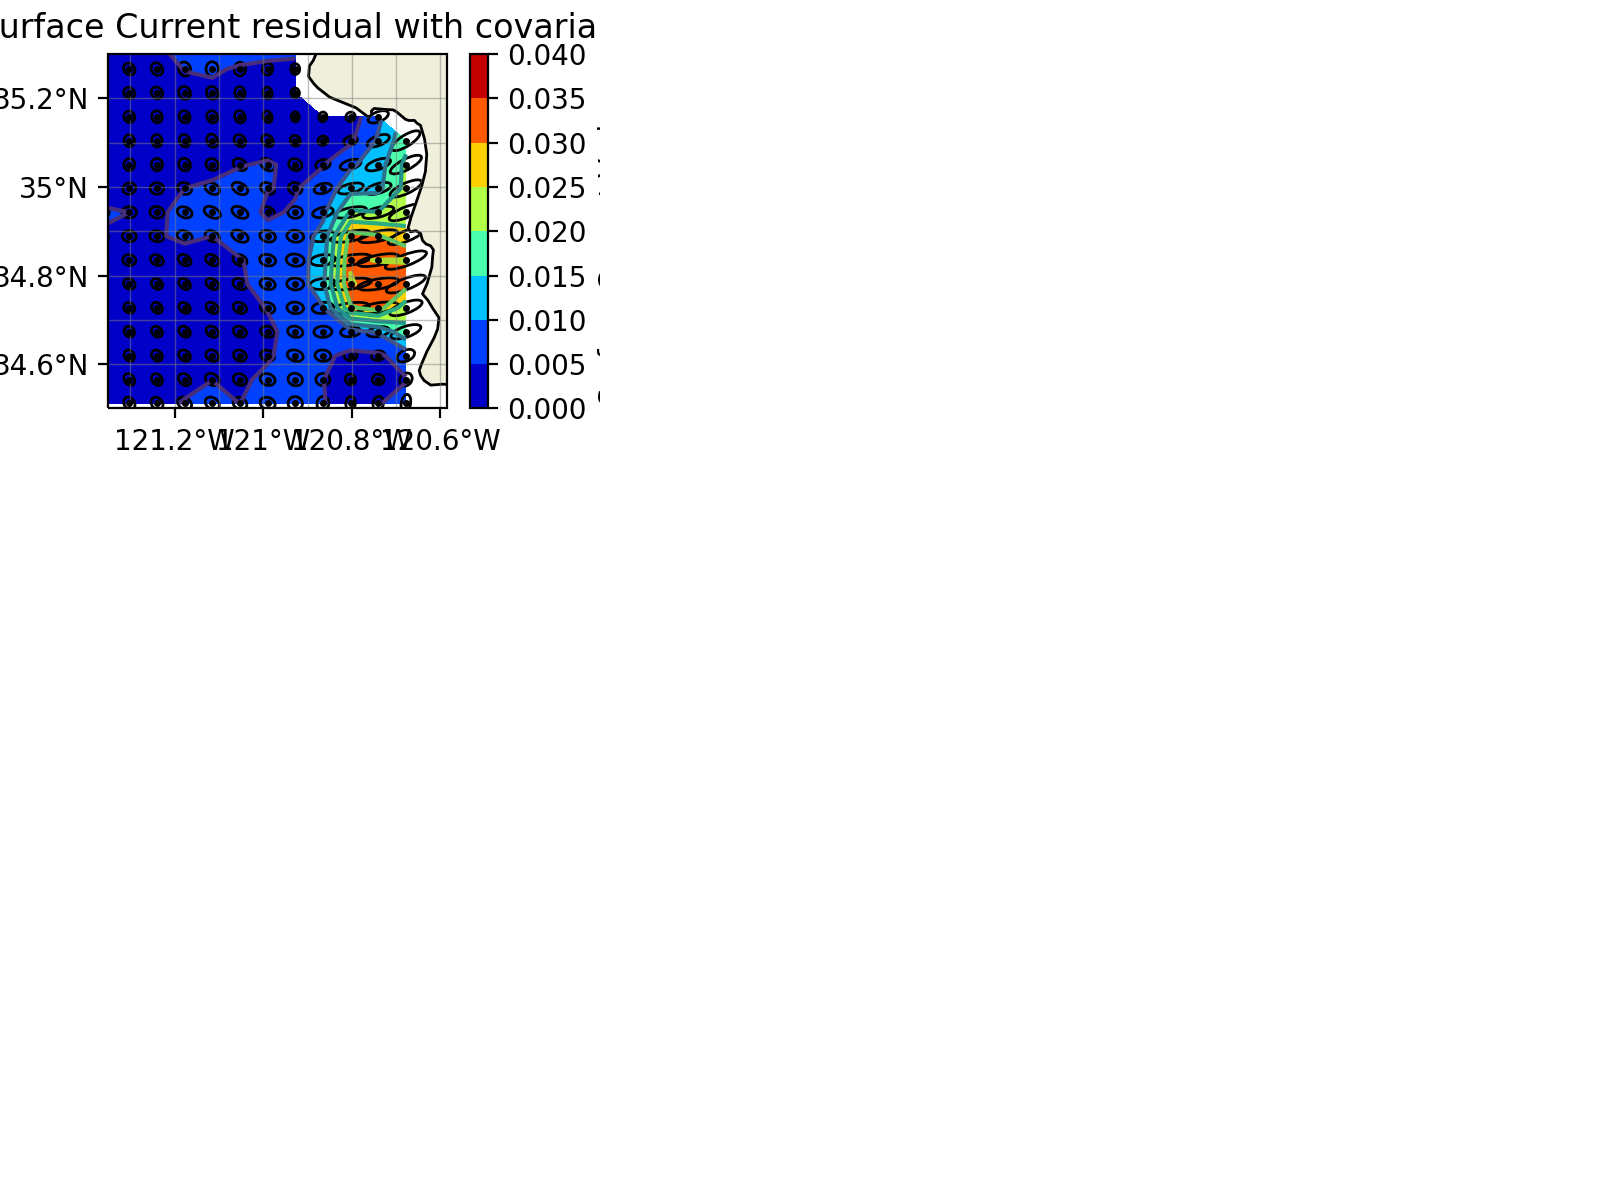

In [28]:
variance=np.sqrt(data['resu'].var('time')**2+data['resv'].var('time')**2)
pscale=8

fig=plt.figure(figsize=(8,6))
ax8 = plt.axes(projection=crs.PlateCarree())
ax8.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax8.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax8.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax8.xaxis.set_major_formatter(LongitudeFormatter())
ax8.yaxis.set_major_formatter(LatitudeFormatter())

for i in np.arange(0,data.lat.size):
    for j in np.arange(0,data.lon.size):
        w=data['varw_res'].isel(lat=i,lon=j)
        h=data['varh_res'].isel(lat=i,lon=j)
        theta=data['vart_res'].isel(lat=i,lon=j)
        
        ell = Ellipse(xy=(data.lon.isel(lon=j),data.lat.isel(lat=i)),
              width=w/pscale, height=h/pscale,
              angle=theta, color='black',linewidth=1)
        ell.set_facecolor('none')
        ax8.add_patch(ell)
ax8.set_extent([-121.35,-120.585,34.5,35.3])

CF=ax8.contourf(lon,lat,variance,cmap='jet')
ax8.contour(lon,lat,variance)
ax8.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax8.plot(glon,glat,'k.',ms=3)
ax8.set_title('Variance of Surface Current residual with covariance Ellipse')
plt.colorbar(CF,label="Surface Current Variance")
ax8.coastlines(resolution='10m',color='k')


